# PCA Analysis

Purpose: Exploring the effectiveness of PCA for compressing patient scans. A compression technique is required, as the scans in their original size are too big and will take too long to be analyzed by neural networks.

In [122]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob
import re
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from time import time

In [123]:
# constants

data = '/kaggle/dev/data-science-bowl-2017-data/'
stage1 = '/kaggle/dev/data-science-bowl-2017-data/stage1/'
sample_images = '/kaggle/dev/data-science-bowl-2017-data/sample_images/'
labels = '/kaggle/dev/data-science-bowl-2017-data/stage1_labels.csv'
stage1_processed = '/kaggle/dev/data-science-bowl-2017-data/stage1_processed/'
stage1_features = '/kaggle/dev/data-science-bowl-2017-data/stage1_features_mx/'
stage1_submission = '/kaggle/dev/data-science-bowl-2017-data/stage1_sample_submission.csv'
naive_submission = '/kaggle/dev/jovan/data-science-bowl-2017/data-science-bowl-2017/submissions/naive_submission.csv'

In [124]:
sample_ids = []

for d in os.listdir(sample_images):
    sample_ids.append(d)
    print("Patient '{}' has {} scans".format(d, len(os.listdir(sample_images + d))))

print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(stage1)), 
                                                      len(glob.glob(stage1 + '*/*.dcm'))))

Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 180 scans
Patient '0d19f1c627df49eb223771c28548350e' has 183 scans
Patient '0c37613214faddf8701ca41e6d43f56e' has 164 scans
Patient '0d2fcf787026fece4e57be167d079383' has 126 scans
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 110 scans
Patient '00cba091fa4ad62cc3200a657aeb957e' has 134 scans
Patient '0d941a3ad6c889ac451caf89c46cb92a' has 177 scans
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 133 scans
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 136 scans
Patient '0c9d8314f9c69840e25febabb1229fa4' has 221 scans
Patient '0ca943d821204ceb089510f836a367fd' has 147 scans
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 scans
Patient '0c0de3749d4fe175b7a5098b060982a1' has 123 scans
Patient '0c59313f52304e25d5a7dcf9877633b1' has 244 scans
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 280 scans
Patient '0de72529c30fe642bc60dcb75c87f6bd' has 113 scans
Patient '0ddeb08e9c97227853422bd71a2a695e' has 171 scans
Patient '0a099f2549429d29b32f34

In [125]:
print("Analysis will be done on:")
num_patients = 2 # number of patients to analyze
segmented_lungs_fill = []

for folder in glob.glob(stage1_processed + 'segment_lungs_fill_*'):
    m = re.match(r'segment_lungs_fill_([a-f0-9].*).npy', os.path.basename(folder))
    if(m.group(1) in sample_ids[0:num_patients]):
        x = np.load(stage1_processed + m.group(0))
        segmented_lungs_fill.append(x)
        print('Patient {}: array shape: {}'.format(m.group(1), x.shape))
        


Analysis will be done on:
Patient 0d19f1c627df49eb223771c28548350e: array shape: (366, 370, 370)
Patient 0c98fcb55e3f36d0c2b6507f62f4c5f1: array shape: (360, 350, 350)


In [126]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
#     ax.invert_zaxis()


    plt.show()

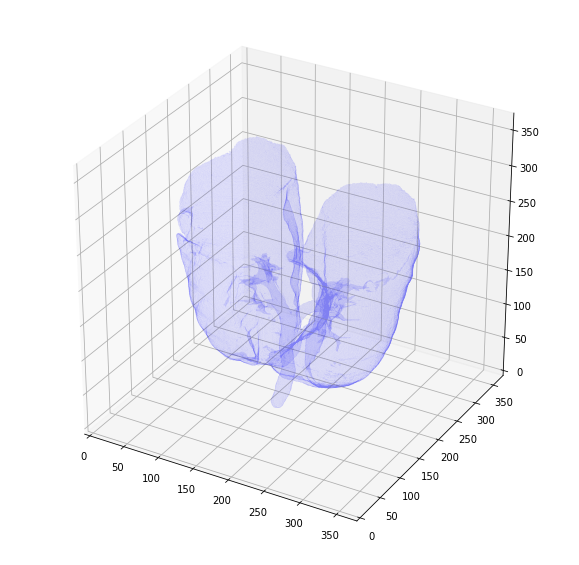

In [127]:
plot_3d(segmented_lungs_fill[0], 0)

In [128]:
x = segmented_lungs_fill[0].shape[0]
y = segmented_lungs_fill[0].shape[1]
z = segmented_lungs_fill[0].shape[2]
print(x,y,z,segmented_lungs_fill[0].shape)

366 370 370 (366, 370, 370)


In [133]:
patient_0 = segmented_lungs_fill[0].reshape(segmented_lungs_fill[0].shape[0],
                                            segmented_lungs_fill[0].shape[1]*segmented_lungs_fill[0].shape[2])
print(patient_0.shape)


(366, 136900)


In [168]:
n_components = 100
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(patient_0)

eigenfaces = pca.components_.reshape((n_components, y, z))
print("shape: " + str(eigenfaces.shape))

print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_pca = pca.transform(patient_0)
print("done in %0.3fs" % (time() - t0))


shape: (100, 370, 370)
Projecting the input data on the eigenfaces orthonormal basis
done in 4.281s


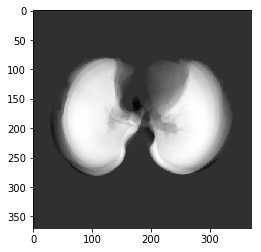

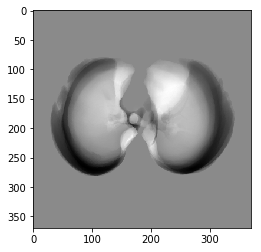

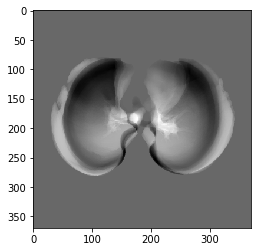

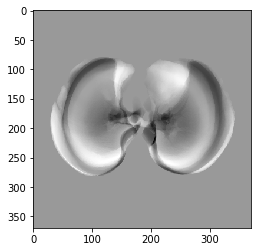

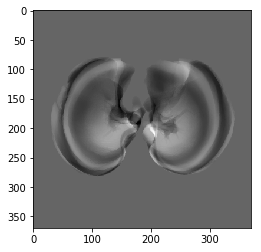

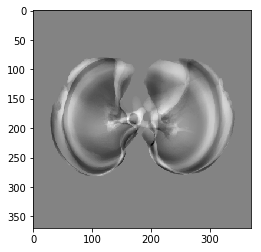

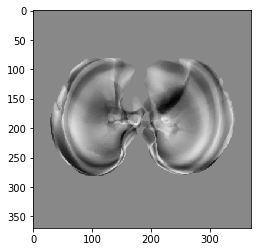

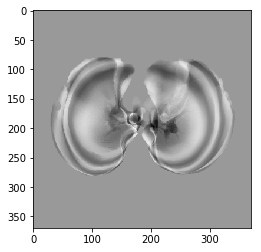

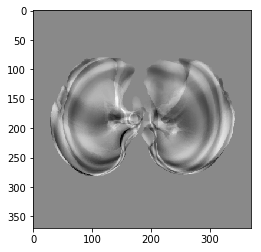

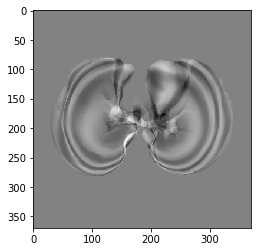

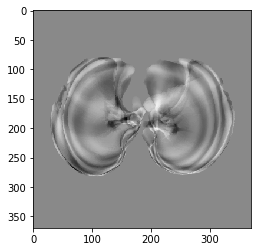

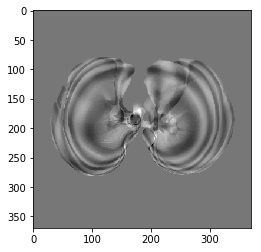

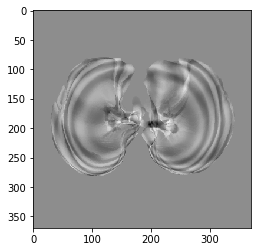

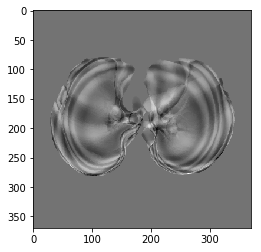

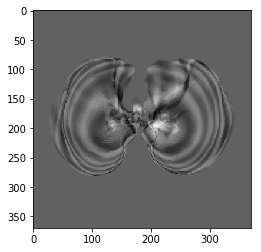

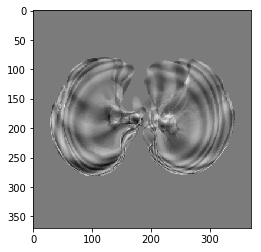

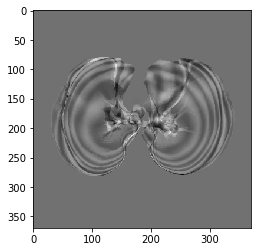

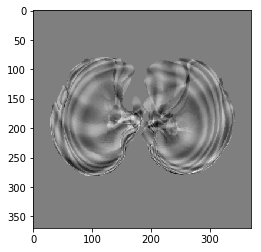

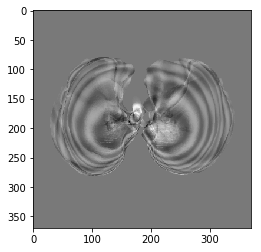

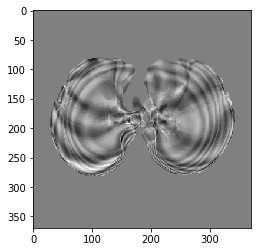

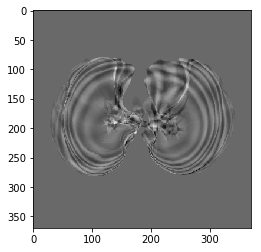

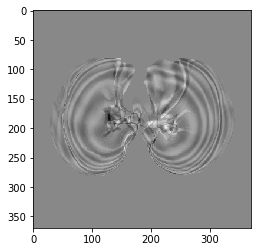

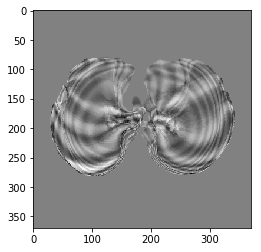

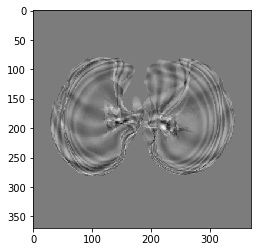

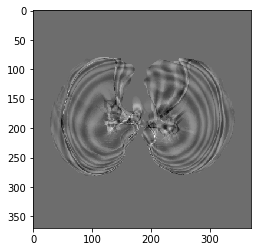

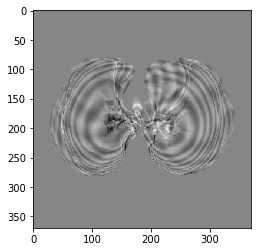

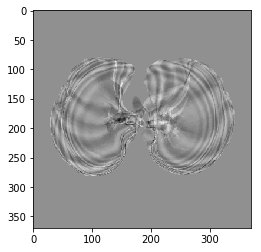

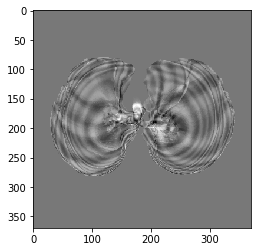

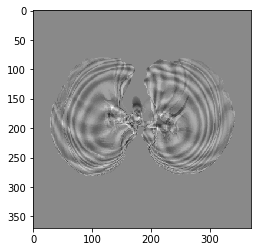

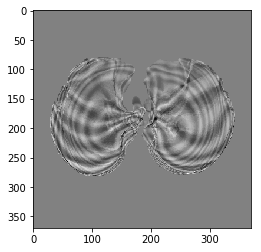

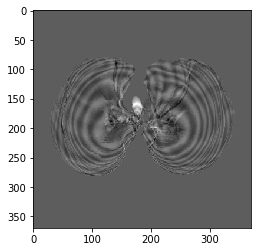

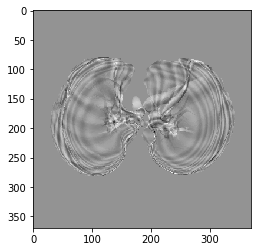

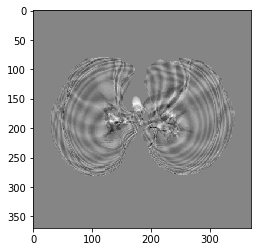

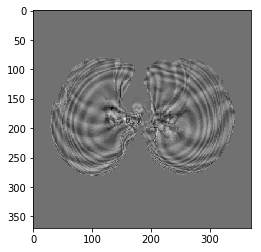

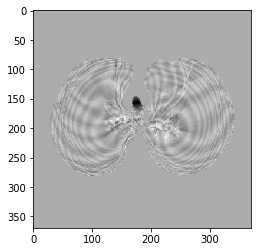

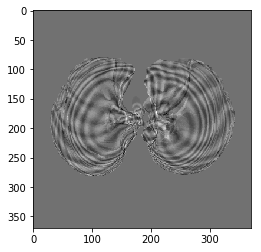

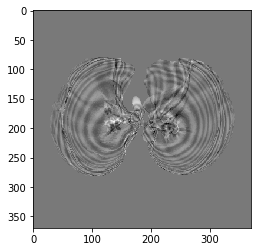

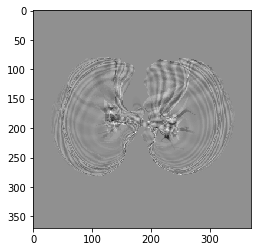

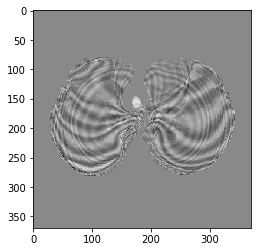

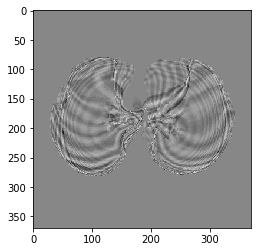

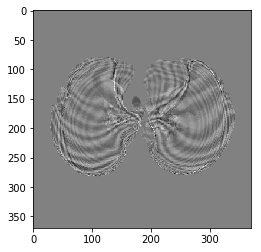

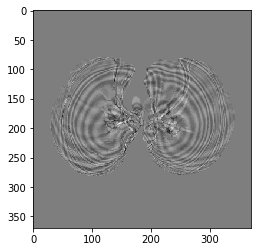

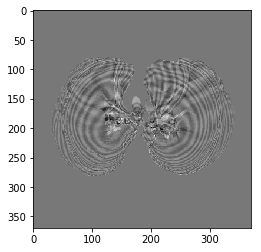

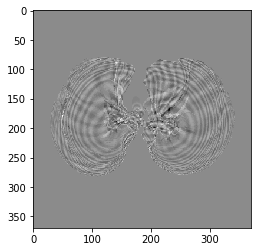

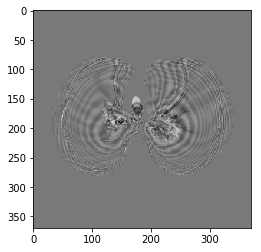

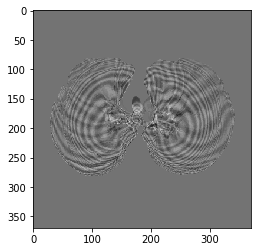

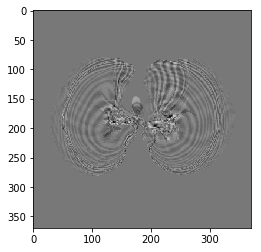

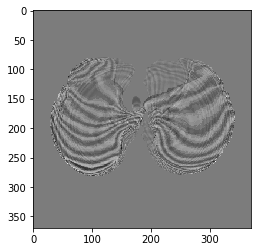

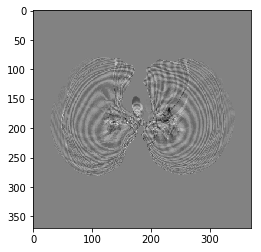

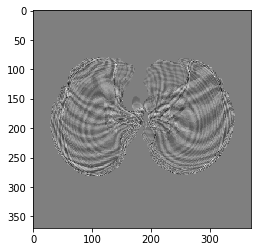

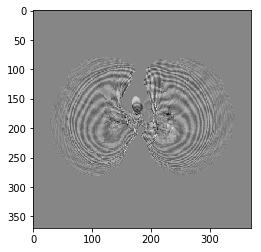

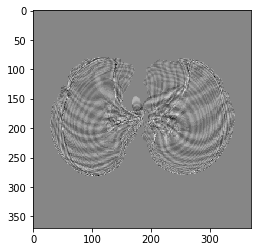

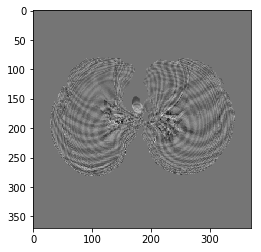

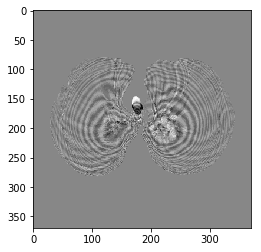

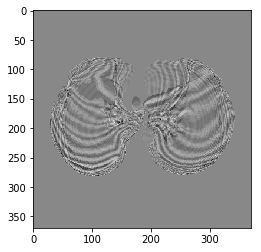

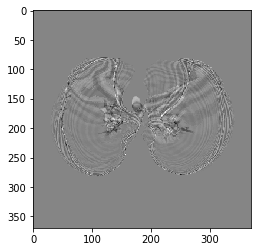

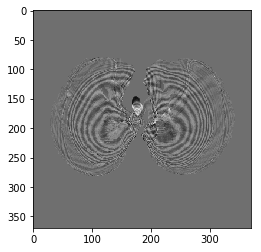

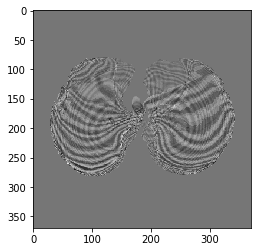

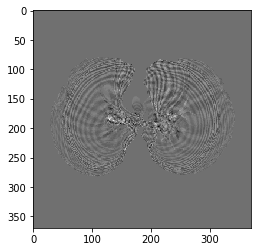

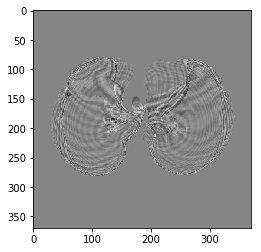

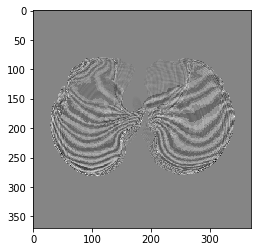

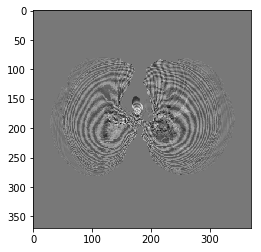

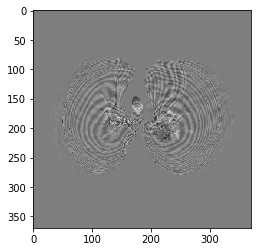

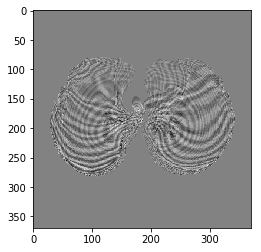

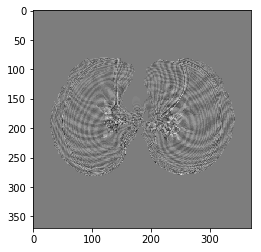

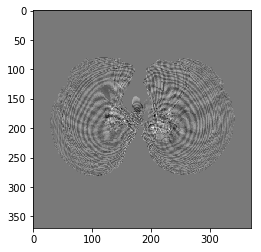

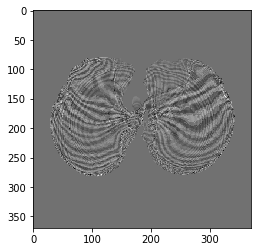

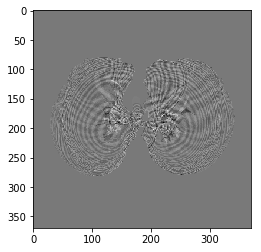

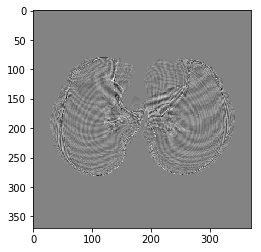

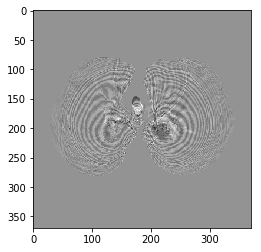

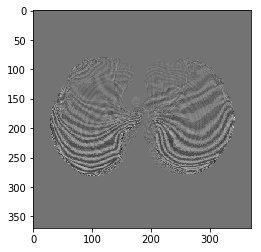

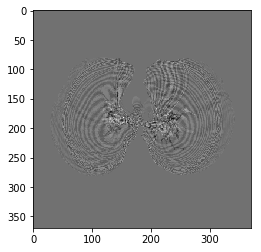

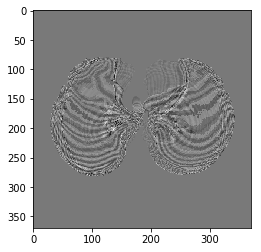

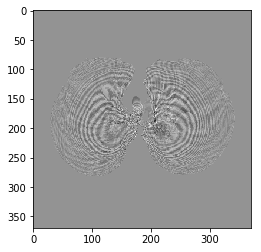

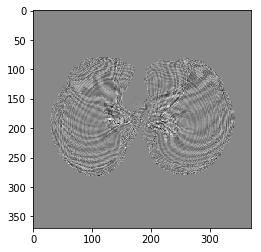

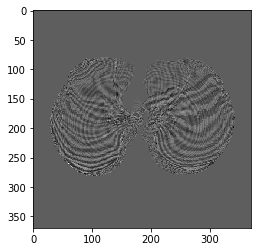

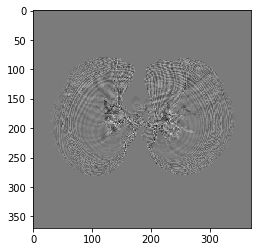

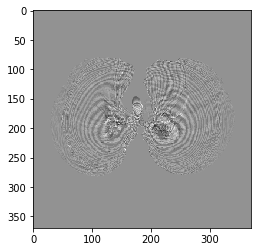

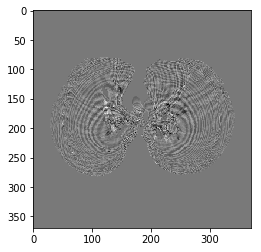

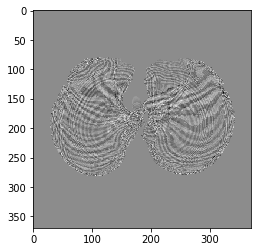

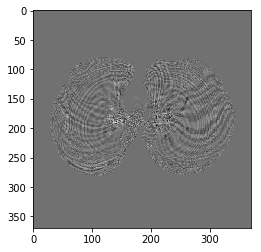

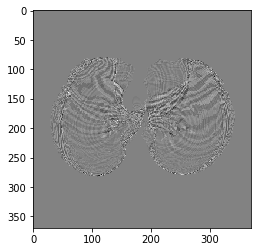

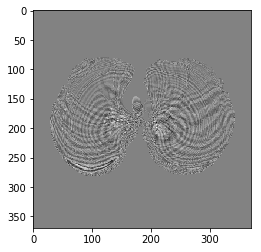

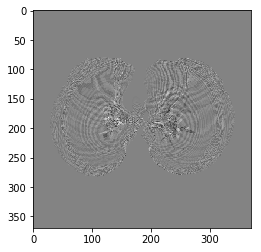

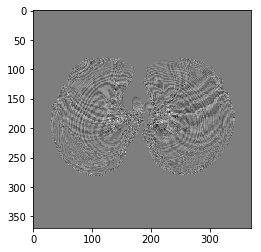

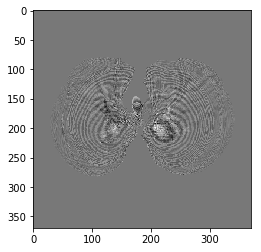

In [169]:
for i in range(0,n_components):
   plt.imshow(eigenfaces[i].reshape((y, z)), cmap=plt.cm.gray)
   plt.show()

In [173]:
explained_variance_ratio  = (pca.explained_variance_ratio_) 
for i in explained_variance_ratio:
    print(": " + str(i))
    if i <= 0.001:
        print("lower: " + str(i))
        print(np.where(explained_variance_ratio <= (i)))
        break
    

: 0.551650977873
: 0.135237654785
: 0.0788290499554
: 0.0475632650271
: 0.0263941261158
: 0.0222794475458
: 0.0147620628714
: 0.0146507226232
: 0.00978154315371
: 0.00918962999256
: 0.00721859362406
: 0.005397578714
: 0.00502245721454
: 0.00454299323986
: 0.00437736297921
: 0.00334096899402
: 0.00308700494525
: 0.00287832907703
: 0.00237784491871
: 0.00227581784841
: 0.00210760815984
: 0.00198447609345
: 0.00182712827267
: 0.00163027338298
: 0.00151323577897
: 0.00143533631199
: 0.00132292413217
: 0.0012758055281
: 0.00120255340067
: 0.00108072922397
: 0.00100852468172
: 0.000980970454674
lower: 0.000980970454674
(array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
       99]),)
